### Install & Import Libraries

In [8]:
# Install required packages from requirements.txt
!pip install -r requirements.txt -q

# importing the clear_output function from IPython.display module to reduce noise in outputs...
from IPython.display import clear_output
from bs4 import BeautifulSoup

# Datahandling
import os

# Network analysis
from typing import List, Optional
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import holoviews as hv
import hvplot.networkx as hvnx
from community import community_louvain
import plotly.graph_objects as go
import random
from community import community_louvain
from collections import defaultdict

# Model prediction
from datasets import Dataset
from setfit import SetFitModel, SetFitTrainer
from sklearn.metrics import classification_report

# Gradio deployment
import gradio as gr


/opt/anaconda3/lib/python3.12/pty.py:95: DeprecationWarning:

This process (pid=81989) is multi-threaded, use of forkpty() may lead to deadlocks in the child.



### Load pre-made JSON data (created from M2_LLM_Data_Fetch_and_Processing.ipynb)
 * The following JSON file has been created using the Jupyter Notebook: 
     * M2_LLM_Data_Fetch_and_Processing.ipynb

In [3]:
# Load the JSON data
with open('breaking_bad_analysisV2.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

## Network Analysis 

In [4]:
# Extract entities and relationships from each episode
entities = set()
relationships = []

for episode_data in data.values():
    for entity in episode_data["entities"]:
        entities.add((entity["name"], entity["type"]))

    for relationship in episode_data["relationships"]:
        relationships.append((relationship["source"], relationship["relation"], relationship["target"], relationship["season"]))

print(f"Loaded {len(entities)} entities and {len(relationships)} relationships.")


Loaded 275 entities and 594 relationships.


In [5]:
# Initialize a directed graph
G = nx.DiGraph()

# Add nodes with their type as an attribute
for name, entity_type in entities:
    G.add_node(name, entity_type=entity_type)

# Add edges with relationship and season as attributes
for source, relation, target, season in relationships:
    G.add_edge(source, target, relation=relation, season=season)

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Graph created with 286 nodes and 493 edges.


In [13]:
# Calculate centrality measures (e.g., degree centrality)
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Calculate network structure indicators
network_density = nx.density(G)
average_clustering = nx.average_clustering(G)

# Check if the graph is connected before calculating average shortest path and diameter
if nx.is_connected(G):
    average_shortest_path = nx.average_shortest_path_length(G)
    diameter = nx.diameter(G)
else:
    average_shortest_path = "Graph is disconnected"
    diameter = "Graph is disconnected"  # Or any other appropriate value

number_of_nodes = G.number_of_nodes()
number_of_edges = G.number_of_edges()

# Print network structure metrics
print("\nNetwork Structure Indicators:")
print(f"Network Density: {network_density:.3f}")
print(f"Average Clustering Coefficient: {average_clustering:.3f}")
print(f"Number of Nodes: {number_of_nodes}")
print(f"Number of Edges: {number_of_edges}")

# Visualization step (placeholder for your visualization code)
# Example:
# import matplotlib.pyplot as plt
# nx.draw(G, with_labels=True)
# plt.show()



Network Structure Indicators:
Network Density: 0.011
Average Clustering Coefficient: 0.325
Number of Nodes: 286
Number of Edges: 451


In [6]:
# Initialize graph
G = nx.Graph()
characters = set()
relationships = []

for episode_data in data.values():
    for entity in episode_data["entities"]:
        if entity["type"] == "Character":
            characters.add(entity["name"])

    for relationship in episode_data["relationships"]:
        relationships.append((relationship["source"], relationship["relation"], relationship["target"], relationship["season"]))

# Add nodes and edges to the graph
for char in characters:
    G.add_node(char, type="Character")

for source, relation, target, season in relationships:
    if source in G and target in G:
        G.add_edge(source, target, relation=relation, season=season)

# Calculate various centrality measures for node significance
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# Create a composite importance score
node_importance = {
    node: (degree_centrality[node] + betweenness_centrality[node] + eigenvector_centrality[node]) / 3
    for node in G.nodes
}

# Scale node sizes based on importance
node_size = [20 + 100 * node_importance[node] for node in G.nodes]

# Use a more spread out layout with stronger repulsion
pos = nx.spring_layout(G, k=1, iterations=50, seed=42)

# Extract edge positions
edge_x, edge_y = [], []
edge_texts = []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    edge_texts.append(f"{edge[0]} - {edge[2]['relation']} - {edge[1]}<br>Season: {edge[2]['season']}")

# Extract node positions
node_x, node_y, node_text = [], [], []
for node in G.nodes:
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(
        f"Character: {node}<br>"
        f"Degree Centrality: {degree_centrality[node]:.3f}<br>"
        f"Betweenness Centrality: {betweenness_centrality[node]:.3f}<br>"
        f"Eigenvector Centrality: {eigenvector_centrality[node]:.3f}"
    )

# Create Plotly figure
fig = go.Figure()

# Add edges
fig.add_trace(go.Scatter(
    x=edge_x,
    y=edge_y,
    mode='lines',
    line=dict(width=0.8, color='rgba(169,169,169,0.5)'),
    hoverinfo='none'
))

# Add nodes
fig.add_trace(go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=[node for node in G.nodes],
    textposition="top center",
    hovertext=node_text,
    hoverinfo='text',
    marker=dict(
        size=node_size,
        color=[node_importance[node] for node in G.nodes],
        colorscale='Viridis',
        line=dict(width=1, color='white'),
        showscale=True,
        colorbar=dict(title="Character Importance")
    )
))

# Customize layout
fig.update_layout(
    title={
        'text': "Breaking Bad Character Network",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    width=1200,
    height=1000,
    showlegend=False,
    hovermode='closest',
    plot_bgcolor='rgb(250,250,250)',
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

# Add zoom capabilities and better interaction
fig.update_layout(
    dragmode='pan',
    clickmode='event+select'
)

fig.show()

In [7]:
G = nx.Graph()
relation_types = set()

for episode_data in data.values():
    for rel in episode_data.get('relationships', []):
        G.add_edge(rel['source'], rel['target'], relation=rel['relation'])
        relation_types.add(rel['relation'])

# Apply community detection for clustering
partition = community_louvain.best_partition(G)
unique_communities = set(partition.values())
community_colors = {community: f'#{random.randint(0, 0xFFFFFF):06x}' for community in unique_communities}

# Separate nodes by community for modular layout
# Create a dictionary to hold positions of each node by community
community_positions = {}
for community in unique_communities:
    # Subgraph for each community
    subgraph = G.subgraph([node for node in G.nodes() if partition[node] == community])
    # Apply spring layout to each community separately
    pos = nx.spring_layout(subgraph, k=0.4, iterations=50)
    community_positions.update(pos)

# Spread communities apart to avoid overlap
offset = 3.0  # Adjust to control spacing between communities
for i, community in enumerate(unique_communities):
    for node in [n for n in G.nodes() if partition[n] == community]:
        community_positions[node][0] += (i % 5) * offset
        community_positions[node][1] += (i // 5) * offset

# Create color map for relation types
relation_colors = {rel: f'#{random.randint(0, 0xFFFFFF):06x}' for rel in relation_types}

# Create edge traces with color based on relation type
edge_traces = [
    go.Scatter(
        x=[community_positions[e[0]][0], community_positions[e[1]][0], None],
        y=[community_positions[e[0]][1], community_positions[e[1]][1], None],
        line=dict(width=0.5, color=relation_colors[e[2]['relation']]),
        hoverinfo='text',
        text=e[2]['relation'],
        mode='lines'
    ) for e in G.edges(data=True)
]

# Calculate node sizes based on degree
node_sizes = [10 + 5 * G.degree(node) for node in G.nodes()]

# Create node trace with community-based coloring
node_trace = go.Scatter(
    x=[community_positions[node][0] for node in G.nodes()],
    y=[community_positions[node][1] for node in G.nodes()],
    mode='markers+text',
    text=list(G.nodes()),
    textposition="top center",
    hoverinfo='text',
    marker=dict(
        size=node_sizes,
        color=[community_colors[partition[node]] for node in G.nodes()],
        line=dict(width=2)
    ),
    textfont=dict(size=8)
)

# Create figure
fig = go.Figure(data=edge_traces + [node_trace])
fig.update_layout(
    title="Breaking Bad Network with Clustered Community Colors",
    showlegend=False,
    width=1200,
    height=1000,
    hovermode='closest',
    margin=dict(b=20, l=5, r=5, t=40),
    annotations=[dict(
        text="Breaking Bad Network with Clustered Community Colors",
        showarrow=False,
        xref="paper", yref="paper",
        x=0.005, y=-0.002
    )],
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

fig.show()


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

/var/folders/z7/j9rhznl118zbt_41ygz3rgyc0000gn/T/ipykernel_81989/3489248240.py:44: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



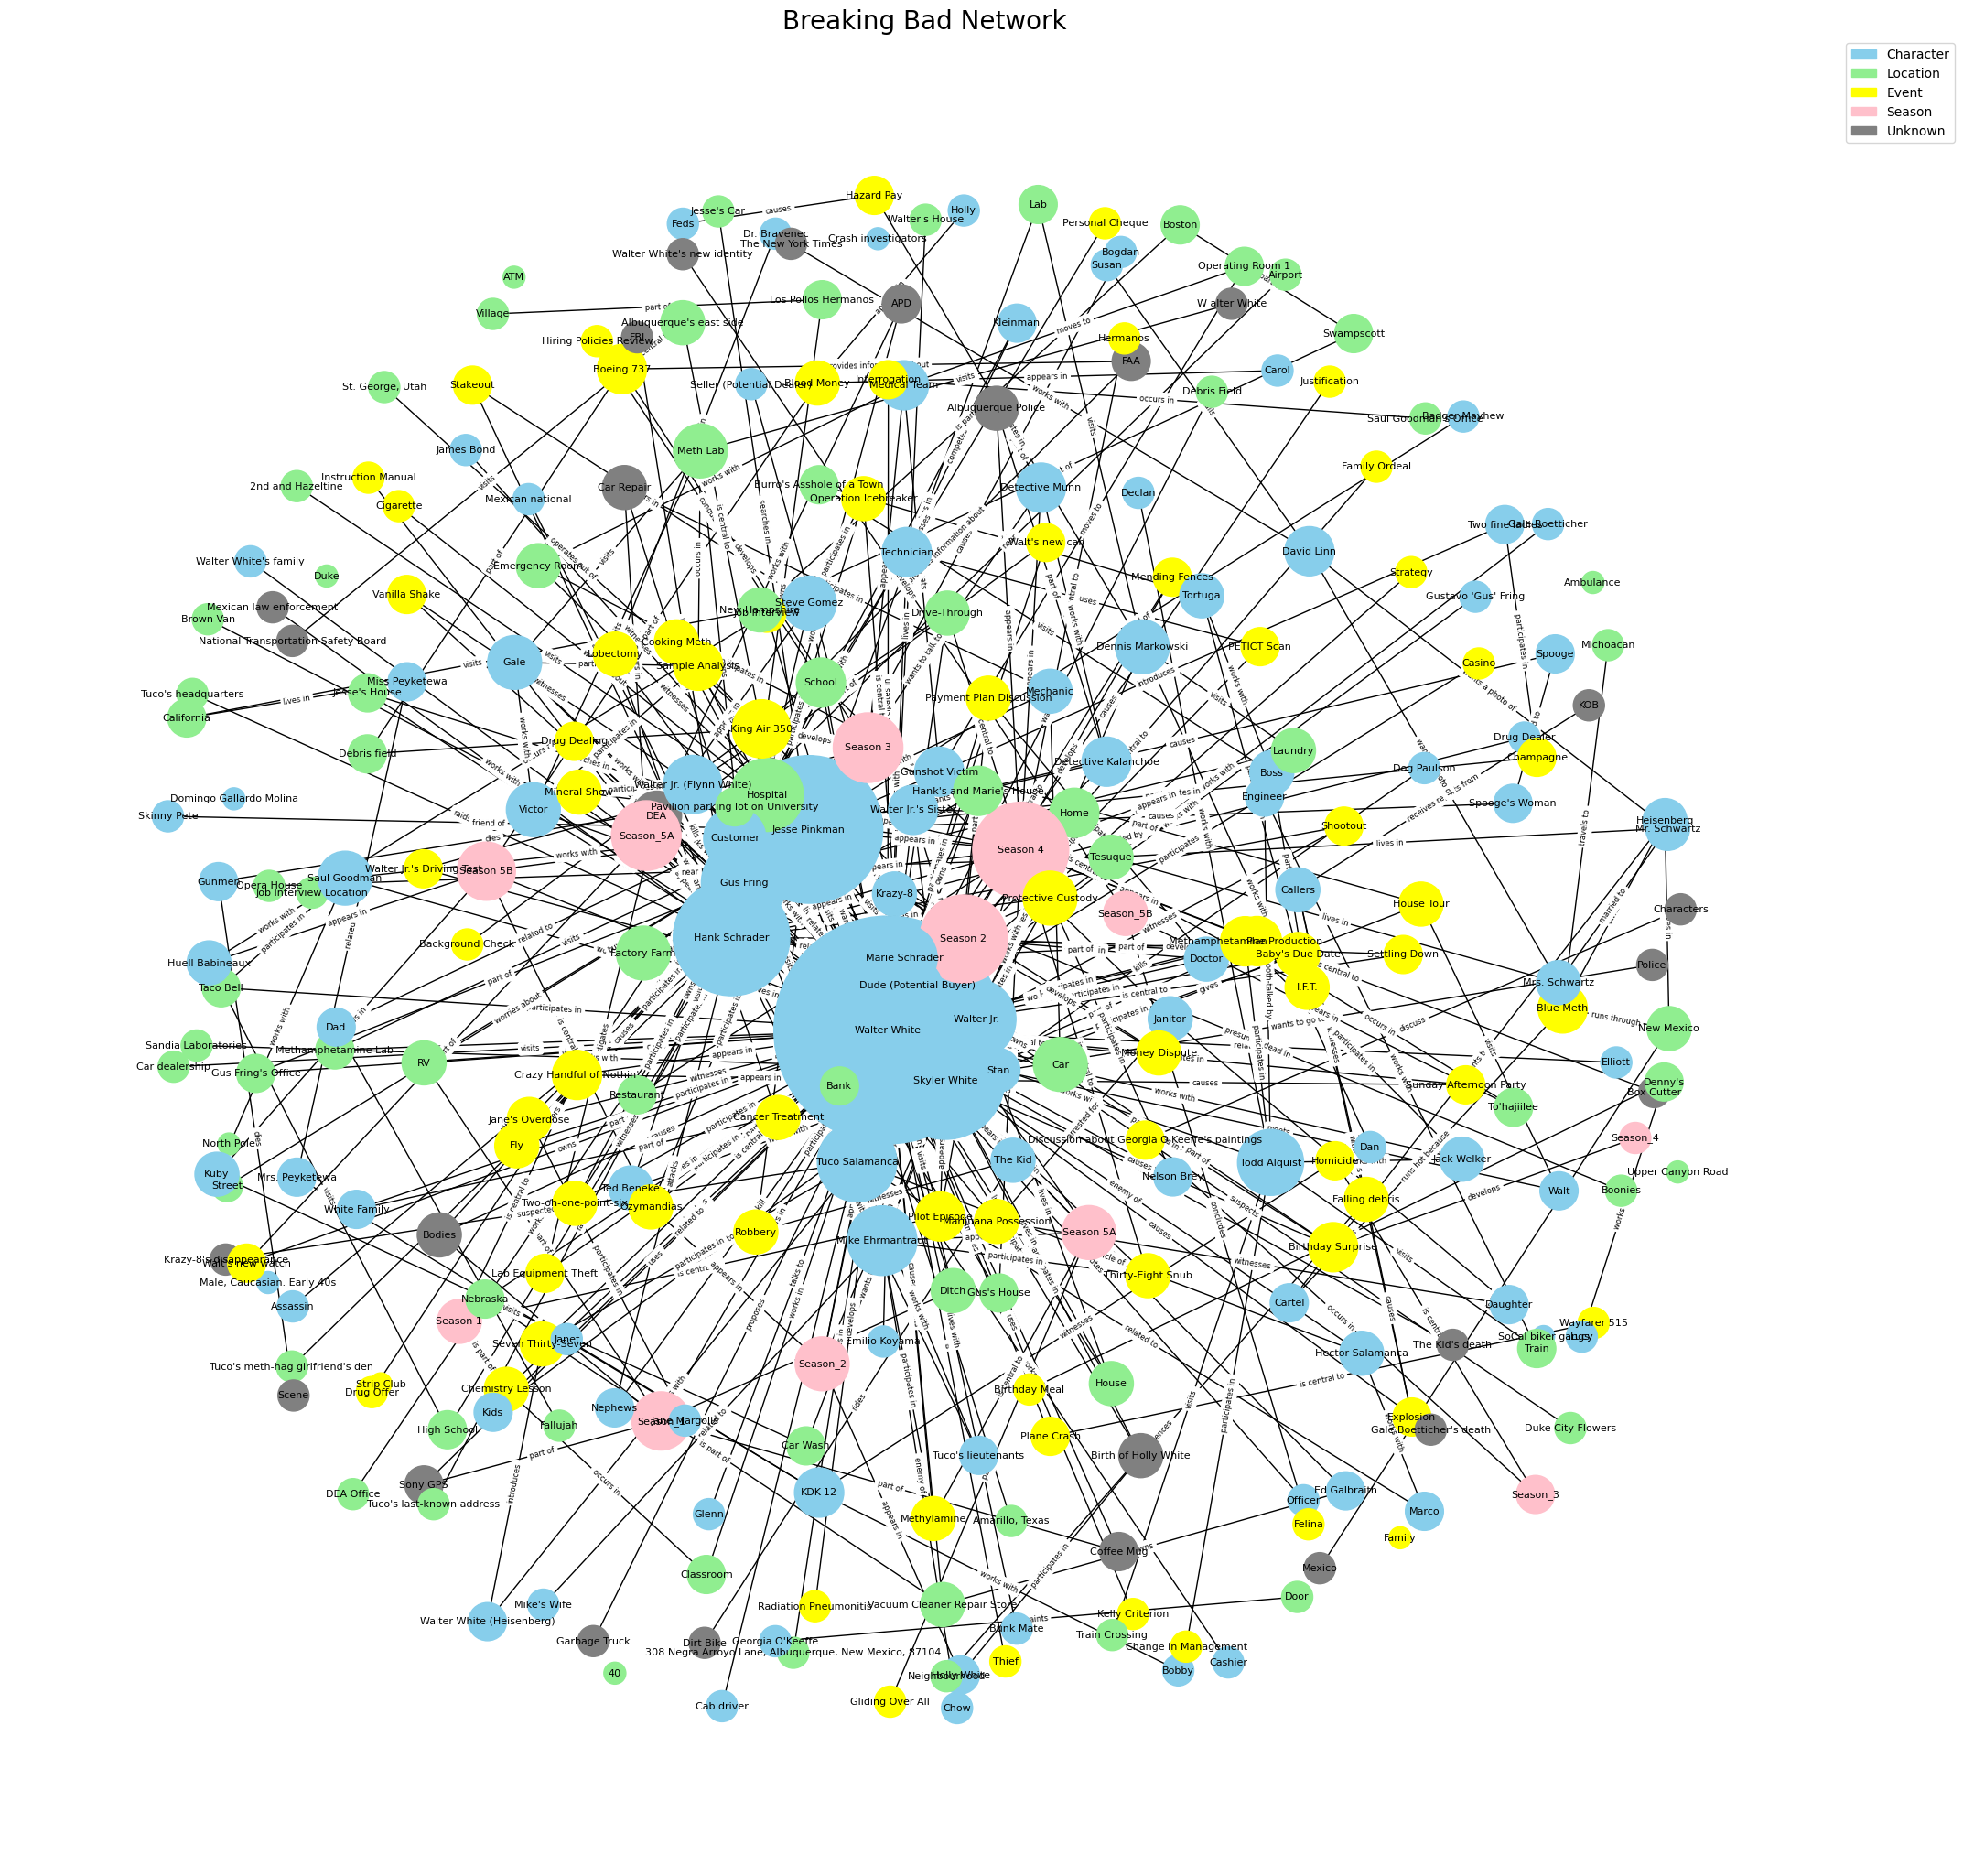

Network visualization has been saved as 'breaking_bad_network.png'


In [9]:
# Opret en graf
G = nx.Graph()

# Tilføj noder og kanter
for episode, content in data.items():
    for entity in content['entities']:
        G.add_node(entity['name'], type=entity['type'])
    
    for relation in content['relationships']:
        source = relation['source']
        target = relation['target']
        if source not in G.nodes():
            G.add_node(source, type='Unknown')
        if target not in G.nodes():
            G.add_node(target, type='Unknown')
        G.add_edge(source, target, 
                   relation=relation['relation'], 
                   season=relation['season'])

# Definer farver for forskellige nodetyper
color_map = {'Character': 'skyblue', 'Location': 'lightgreen', 
             'Event': 'yellow', 'Season': 'pink', 'Unknown': 'gray'}

# Få node farver og størrelser
node_colors = [color_map.get(G.nodes[node].get('type', 'Unknown'), 'gray') for node in G.nodes()]
node_sizes = [300 * (1 + G.degree(node)) for node in G.nodes()]

# Tegn grafen
plt.figure(figsize=(20,20))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=node_sizes, font_size=8)

# Tilføj kant labels
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

# Tilføj legende
import matplotlib.patches as mpatches
legend_elements = [mpatches.Patch(color=color, label=type) for type, color in color_map.items()]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

plt.title("Breaking Bad Network", fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.savefig("breaking_bad_network.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

print("Network visualization has been saved as 'breaking_bad_network.png'")

## Text Classification

In [10]:
# Load pre_trained model
model = SetFitModel.from_pretrained('saved_model')

# read JSON data and extract only characters
with open("breaking_bad_analysisV2.json", "r") as file:
    data = json.load(file)

# find all unique characters from "entities"
characters = set()
for episode, episode_data in data.items():
    for entity in episode_data["entities"]:
        if entity["type"] == "Character":
            characters.add(entity["name"])

# convert to a sorted list for consistent display
characters = sorted(characters)

# function to compare the relationship between two selected characters
def compare_relationships(model, char1, char2):
    result = f"Comparing relationship between {char1} and {char2}:\n"
    
    # test relationship both ways
    forward = model.predict([f"{char1} - {char2}"])[0]
    backward = model.predict([f"{char2} - {char1}"])[0]
    
    # add the result for each pair
    result += f"\n{char1} <-> {char2}:\n"
    result += f"  {char1} -> {char2}: {forward}\n"
    result += f"  {char2} -> {char1}: {backward}\n"
    
    return result

# gradio interface function
def gradio_interface(char1, char2):
    return compare_relationships(model, char1, char2)

# create dropdown menus with character options
char1_dropdown = gr.Dropdown(choices=characters, label="Select first character (char1)")
char2_dropdown = gr.Dropdown(choices=characters, label="Select second character (char2)")
output = gr.Textbox(label="Results")

# initialize and start the gradio app
gr.Interface(fn=gradio_interface, inputs=[char1_dropdown, char2_dropdown], outputs=output, title="Relationship Comparison").launch()


You try to use a model that was created with version 3.2.1, however, your version is 3.1.1. This might cause unexpected behavior or errors. In that case, try to update to the latest version.



/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning:

Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/opt/anaconda3/lib/python3.12/site-packages/gradio/routes.py:1215: DeprecationWarning:


        on_event is deprecated, use lifespan event handlers instead.

        Read more about it in the
        [FastAPI docs for Lifespan Events](https://fastapi.tiangolo.com/advanced/events/).
        

/opt/anaconda3/lib/python3.12/site-packages/fastapi/applications.py:4495: DeprecationWarning:


        on_event is deprecated

Running on local URL:  http://127.0.0.1:7861


/opt/anaconda3/lib/python3.12/site-packages/gradio/analytics.py:106: UserWarning:

IMPORTANT: You are using gradio version 4.44.0, however version 4.44.1 is available, please upgrade. 
--------




To create a public link, set `share=True` in `launch()`.


/opt/anaconda3/lib/python3.12/site-packages/starlette/templating.py:161: DeprecationWarning:

The `name` is not the first parameter anymore. The first parameter should be the `Request` instance.
Replace `TemplateResponse(name, {"request": request})` by `TemplateResponse(request, name)`.

